Importing necessary libraries

In [3]:
import numpy as np
import pandas as pd
import random
import h5py
import warnings
from matplotlib import pyplot as plt
import torch
import math
import torchvision.models as models
import cv2 as cv
import time
from torch.utils.data import Dataset, DataLoader, Sampler
import csv
from torchvision.transforms import transforms
from tqdm import tqdm
import torch.nn as nn
import os

In [4]:
training_transform  = transforms.Compose([transforms.RandomRotation(90,transforms.InterpolationMode.NEAREST,fill= 450),
                                transforms.Normalize(mean=[(0.485+0.456+0.406)/3], std=[(0.229+0.224+0.225)/3]),
                                transforms.RandomCrop((150,150)),
                                transforms.Resize((224,224))])
testing_transform = transforms.Compose([transforms.Normalize(mean=[(0.485+0.456+0.406)/3], std=[(0.229+0.224+0.225)/3]),
                                transforms.CenterCrop((150,150)),
                                transforms.Resize((224,224))])

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [53]:
# class AnchorNeighborIndex(Sampler):
#     def __init__(self, dataset, batch_size):
#         self.n_samples = len(dataset)
#         self.batch_size = batch_size
#         lastIndex = [70498]
#         self.listIndex = list(range(len(dataset)))+lastIndex
#         self.y = np.array_split(self.listIndex,23500)
#         self.indexOfIndexes = list(range(len(self.y)))
#         random.shuffle(self.indexOfIndexes)  
    
#     def __iter__(self):
#         noOfBatches = self.n_samples//self.batch_size
#         noOfChunks = self.batch_size//3
#         finalIndexs = [random.sample(self.indexOfIndexes,noOfChunks) for i in range((noOfBatches))]
        
#         # final indexs are 5875
#         batch = [[(self.y[index]) for index in indexs] for indexs in finalIndexs]
#         final = [batch[i][0].tolist()+batch[i][1].tolist()+batch[i][2].tolist()+batch[i][3].tolist() for i in range(len(batch))]
#         return iter(final)
    
#     def __len__(self):
#         return  self.n_samples//self.batch_size

In [92]:
class TrainDataset(Dataset):
    def __init__(self, irData, dataInfo, transform):
        #data loading
        self.x = irData
        self.y = dataInfo
        self.n_samples = irData.shape[0]
        self.transform = transform

    def __getitem__(self,index):
        t1 = self.x[index]
        t2 = self.y[index]
        if self.transform:
            new = torch.tensor(np.array(t1))
            # newun = new.unsqueeze(0)
            newt1 = self.transform(new)
            return (newt1,torch.tensor(t2))
        else:
            return (t1,t2)
    
    def __len__(self):
        return self.n_samples

In [93]:
class ValDataset(Dataset):
    def __init__(self,testdata,info,transform):
        self.x = testdata
        self.y = info
        self.n_samples = testdata.shape[0]
        self.transform = transform
    
    def __getitem__(self, index):
        im = self.x[index]
        lab = self.y[index]
        if self.transform:
            new1 = torch.tensor(np.array(im))
            y = torch.tensor(lab)
            # newim = new1.unsqueeze(0)
            newt = self.transform(new1)
            return (newt,y)
        else:
            return (im,lab)
        
    
    def __len__(self):
        return self.n_samples

In [94]:
def euclideanDistf(p,q):
    x = p-q
    t = 0
    for i in range(x.shape[0]):
        t+=x[i]**2
    f = math.sqrt(t)
    return f

In [95]:
def euclideanDistl(p,q):
    x = abs(p-q)
    return x

In [96]:
def onehotencoding(labels):
    category = []
    dataInfo = labels.numpy()
    for i in range(dataInfo.shape[0]):
        if dataInfo[i]>=137:
            category.append([0,0,0,0,0,0,0,1])
        elif dataInfo[i]<=136 and dataInfo[i]>=113:
            category.append([0,0,0,0,0,0,1,0])
        elif dataInfo[i]<=112 and dataInfo[i]>=96:
            category.append([0,0,0,0,0,1,0,0])
        elif dataInfo[i]<=95 and dataInfo[i]>=83:
            category.append([0,0,0,0,1,0,0,0])
        elif dataInfo[i]<=82 and dataInfo[i]>=64:
            category.append([0,0,0,1,0,0,0,0])
        elif dataInfo[i]<=63 and dataInfo[i]>=34:
            category.append([0,0,1,0,0,0,0,0])
        elif dataInfo[i]<=33 and dataInfo[i]>=20:
            category.append([0,1,0,0,0,0,0,0])
        elif dataInfo[i]<20:
            category.append([1,0,0,0,0,0,0,0])
    yhat = torch.tensor(np.array(category))
    return yhat

In [97]:
activation = {}
def getActivation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


In [98]:
def rl(anchor,neighbor,feat,labels):
    x = euclideanDistf(feat[anchor],feat[neighbor])
    y = euclideanDistl(labels[anchor],labels[neighbor])
    return x/y

IDC loss is calculated as below:

$$l_{IDC} = \sum_{i=1, y_a\neq y_i}^N\log{\frac{r_{ai}}{\sum_{j=1, y_j \neq y_a}^N r_{aj}}}$$

In [99]:
def IDCLoss(features,labels):
    flat = nn.Flatten()
    # converts tensor of size(12,512,1,1) to (12,512)
    f = nn.functional.normalize(features,p=2)
    feat = flat(f)
    noAnchors = int((feat.shape[0])/3)
    loss = 0
    for k in range(noAnchors):
        a = k*3 + 1
        i = a-1
        j = a+1
        rai=0
        raj=0
        if labels[i]!=labels[a]:
            rai = rl(a,i,feat,labels)
        if labels[a]!=labels[j]:
            raj = rl(a,j,feat,labels)
        if rai==0 and raj==0:
            comp1 = 1
            comp2 = 1
        if rai!=0 and raj == 0:
            comp1 = rai/(rai+raj)
            comp2 = 1
        if rai == 0 and raj!=0:
            comp1 = 1
            comp2 = raj/(rai+raj)
        elif rai!=0 and raj!=0:
            comp1 = rai/(rai+raj)
            comp2 = raj/(rai+raj) 
        y = -(torch.log10(torch.tensor(comp1))+torch.log10(torch.tensor(comp2)))
        loss+=y
    return loss

### Reading the Information from the h5 file

In [110]:
# # dataInfo1 = pd.read_hdf("/home/desktop/Desktop/22104412_Docs/CVDL/Tropical Cyclone Intensity Estimation/TCIR/TCIR-ATLN_EPAC_WPAC.h5", key="info", mode='r')
# # dataInfo2 = pd.read_hdf("/home/desktop/Desktop/22104412_Docs/CVDL/Tropical Cyclone Intensity Estimation/TCIR/TCIR-CPAC_IO_SH.h5", key="info", mode='r')
# # Vmax1 = dataInfo1['Vmax']
# # Vmax2 = dataInfo2['Vmax']
# # dataInfo = np.hstack((Vmax1,Vmax2))
# # #deleting unnecessary variables to create space in jupyter
# # del dataInfo1,dataInfo2,Vmax1,Vmax2

# dataInfo = np.load("/home/desktop/Desktop/TCIR-CIRL/dataInfo.npy")

In [59]:
#Validation dataset 2017 data
pathInfo = '/home/desktop/Desktop/22104412_Docs/CVDL/Tropical Cyclone Intensity Estimation/TCIR/TCIR-ALL_2017.h5'
Info = pd.read_hdf(pathInfo, key="info",mode = 'r')
dataTest = Info['Vmax']

In [ ]:
dataF = np.load('/home/desktop/Desktop/22104412_Docs/CVDL/CVDL- Possible Models/Implementation - SOTA Baselines/dataTrain.npy')

In [131]:
irTest = np.load('/home/desktop/Desktop/22104412_Docs/CVDL/CVDL- Possible Models/Implementation - SOTA Baselines/irTest.npy')

In [111]:
# # load "matrix" as numpy ndarray, this could take longer times
# with h5py.File(pathInfo, 'r') as hf:
#     data_matrix = hf['matrix'][:]

In [112]:
# irTest = data_matrix[:,:,:,[0,3]]
# irTest[np.isnan(irTest)] = 0

In [113]:
# irTest = torch.tensor(irTest)

In [114]:
# irTest = irTest.permute(0,3,1,2)

In [115]:
# irTest.shape

In [116]:
# irTest = irTest.numpy()

In [117]:
# irTest.shape

<!-- COmbining the files -->

In [118]:
# pathIR = "/home/desktop/Desktop/22104412_Docs/CVDL/Tropical Cyclone Intensity Estimation/TCIR/Dataset-Extracted-ATLN-EPAC-SH-IO/FInalDataset-Training/Resize224x224/irDataArray.npy"
# pathPMW = "/home/desktop/Desktop/22104412_Docs/CVDL/Tropical Cyclone Intensity Estimation/TCIR/Dataset-Extracted-ATLN-EPAC-SH-IO/FInalDataset-Training/Resize224x224/pmwDataArray.npy"

In [119]:
# ir = np.load(pathIR)
# ir[np.isnan(ir)] = 0

In [120]:
# pmw = np.load(pathPMW)
# pmw[np.isnan(pmw)] = 0

In [121]:
# ir = torch.tensor(ir)

In [122]:
# pmw = torch.tensor(pmw)

In [123]:
# ir = ir.unsqueeze(0)

In [124]:
# pmw = pmw.unsqueeze(0)

In [125]:
# dataF = torch.cat((ir,pmw))

In [126]:
# del ir, pmw

In [127]:
# dataF = dataF.permute(1,0,2,3)

In [128]:
# dataF = dataF.numpy()

In [129]:
# np.save('dataTrain.npy',dataF)

In [130]:
# np.save('irTest.npy',irTest)

Train data = dataF, dataInfo
Test data = irTest, dataTest

### Backbone of the model is RESNET18 trained on Imagenet- utilising the same for the CI task

In [85]:
modelPretrained = models.resnet18(pretrained=True)

In [86]:
modelPretrained
print(modelPretrained.parameters)

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [87]:
numInputFeatures = modelPretrained.fc.in_features
modelPretrained.fc = nn.Linear(numInputFeatures, 8)
modelPretrained.conv1 = nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
modelPretrained = modelPretrained.to(device)

In [88]:
model = modelPretrained.double()

### Pytorch accepts data in Tensor form - converting np to tensor and delteing the variable in anaconda to stop the kernel from dying

In [89]:
torch.cuda.is_available()

True

In [37]:
# irTensor = torch.tensor(irData)
# del irData

In [38]:
# pmwTensor = torch.tensor(pwmData)
# del pwmData

In [100]:
trainDS = TrainDataset(dataF, dataInfo, transform=training_transform)
# anchorNeighborIndexSampler = AnchorNeighborIndex(trainDS,12)
trainDL = DataLoader(dataset = trainDS, batch_size = 12, shuffle = False, drop_last=False)
data = next(iter(trainDL))
im,lab = data

In [101]:
print(im.shape)

torch.Size([12, 2, 224, 224])


In [102]:
valDS = ValDataset(irTest,dataTest,transform=testing_transform)
valDL = DataLoader(dataset=valDS,batch_size = 12, shuffle = False, drop_last=False)
dataval = next(iter(valDL))
imval,labval=dataval

In [103]:
imval.shape

torch.Size([12, 2, 224, 224])

In [104]:
print(len(trainDL))
print(len(valDL))

5875
382


In [105]:
# #model instance
# modelPretrained = models.resnet18(pretrained=False)
# numInputFeatures = modelPretrained.fc.in_features
# modelPretrained.fc = nn.Linear(numInputFeatures, 8)
# modelPretrained.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# modelPretrained = modelPretrained.double()
# CIExtractor = torch.load('/home/desktop/Desktop/22104412_Docs/CVDL/CVDL- Possible Models/Implementation - SOTA Baselines/checkpoint_Complete_24_per_batch3')
# modelPretrained = modelPretrained.to(device)
# modelPretrained.load_state_dict(CIExtractor)

In [106]:
model.avgpool.register_forward_hook(getActivation('avgpool'))

In [107]:

warnings.simplefilter('ignore', UserWarning)

batchsize = 24
num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
start_time = time.time()
trainLoss=[]
valLoss = []
trainAcc = []
valAcc = []

for epoch in range(num_epochs):
    with tqdm(trainDL, unit='batch') as tepoch:
        trainAccuracy = 0
        totalLoss = 0
        #print("Epoch {} running".format(epoch))# know what is the epoch running
        model.train()
        for images,lab in tepoch:
            labels = onehotencoding(lab)
            images = images.to(device)
            labels = labels.to(device)
            h1 = model.avgpool.register_forward_hook(getActivation('avgpool'))
            avgpool_list=[]
            optimizer_ft.zero_grad()
            outputs = (model(images.double())).float()
            _,predindex = torch.max(outputs,dim=1)
            _,labelsind = torch.max(labels,dim=1)
            ## feature extraction for IDC loss
            avgpool_list.append(activation['avgpool'])
            features = avgpool_list[0]
            h1.remove()
            lossIDC = IDCLoss(features,lab)
            lossCE = criterion(outputs,labels.float())
            loss = 1.3*lossCE+lossIDC
            loss.backward()
            totalLoss+=loss.item()
            optimizer_ft.step()
            y = (predindex==labelsind).sum().item()
            batchAccuracy = y/batchsize
            trainAccuracy += y
            totaltrainAccuracybatch = trainAccuracy/(len(trainDL)*batchsize)
            tepoch.set_postfix(loss=loss.item(),totalLoss =totalLoss/len(trainDL), TrainAccuracyPerBatch = 100.*totaltrainAccuracybatch)      
        model.eval()
        with torch.no_grad():
              with tqdm(valDL, unit='batch') as tepoch:
                    total = 0
                    correct = 0
                    for images,lab in tepoch:
                        labels = onehotencoding(lab)
                        images = images.to(device)
                        labels = labels.to(device)
                        outval = (model(images.double())).float()
                        _,predindexval = torch.max(outval,dim=1)
                        _,labelsindval = torch.max(labels,dim=1)
                        total += labels.size(0)
                        correct += (predindexval == labelsindval).sum().item()
                        lossv = criterion(outval,labels.float())
                        val_loss = lossv.item()
    pathSave = "./checkpoint_Complete_12_per_batch_irpmw"+str(epoch)
    torch.save(model.state_dict(), pathSave)
    print('Epoch [{}], Loss_t: {:.4f}, train_acc:{:.4f}, val_acc:{:.4f}'.format(epoch, totalLoss/len(trainDL), 100.*totaltrainAccuracybatch, 100.*correct/total))
    trainLoss.append(totalLoss)
    valLoss.append(val_loss)
    trainAcc.append(totaltrainAccuracybatch)
    valAcc.append(correct/total)

  0%|          | 14/5875 [00:14<1:38:09,  1.00s/batch, TrainAccuracyPerBatch=0.0674, loss=1.07, totalLoss=0.00406]  


KeyboardInterrupt: 

In [39]:
np.save('tl_24.npy',trainLoss)
np.save('vl_24.npy',valLoss)
np.save('ta_24.npy',trainAcc)
np.save('va_24.npy',valAcc)

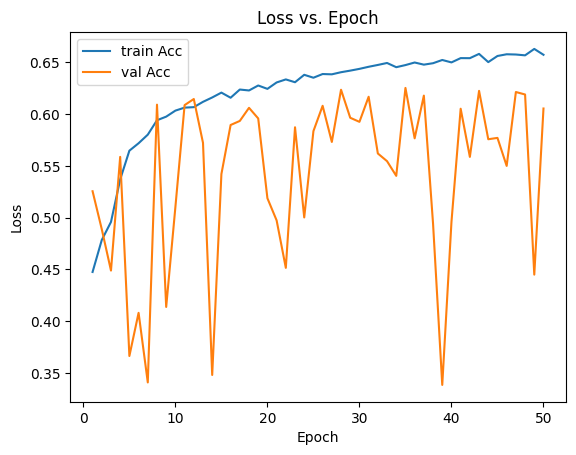

In [42]:
x = np.linspace(1,50,num = 50)
y1 = trainAcc
y2 = valAcc
plt.plot(x,y1,label='train Acc')
plt.plot(x,y2,label='val Acc')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

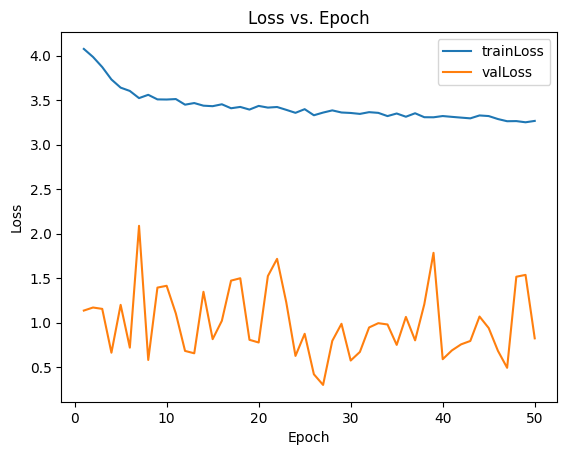

In [47]:
x = np.linspace(1,50,num = 50)
y1 = [trainLoss[i]/len(trainDL) for i in range(len(trainLoss))]
y2 = valLoss
plt.plot(x,y1,label='trainLoss')
plt.plot(x,y2,label='valLoss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()